<!-- # Notebook for Simulating $\hat c_j^i$ Distribution -->

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex

from numpy import linalg as LA

## Configuration

### $X^i$ ~ $N(0, I_d)$
### $w^i$ ~ $U[-10, 10]$

Creating the toy dataset with n = 200, $m_i$ = 10, and d = 10.

In [39]:
NUM_SAMPLES = 10
NUM_CLIENTS = 50
NUM_CLUSTERS = 2

## Creating Dataset

In [40]:
def get_data(num_features, num_clusters=NUM_CLUSTERS, num_clients=NUM_CLIENTS, num_training_samples=NUM_SAMPLES):
    w = np.random.uniform(-5,5,(num_clusters,num_features)) # here we shape all w for all clients



    X = np.zeros ((num_clusters,num_clients,num_training_samples,num_features)) 
    y = np.zeros ((num_clusters,num_clients,num_training_samples))
    localdatasets = np.zeros((num_clusters,num_clients,num_training_samples,(num_features+1)))
    clusterassgts = np.zeros((num_clusters,num_clients,num_training_samples))
    for iter_cluster in range(num_clusters): 
        for iter_node in range(0, num_clients):
            X[iter_cluster, iter_node,:,:] = np.random.randn(num_training_samples, num_features)
            r = X[iter_cluster, iter_node,:,:] @ w[iter_cluster, :].reshape(-1, 1) + 0 * np.random.randn(num_training_samples,1)
            y[iter_cluster, iter_node,:] = r.squeeze()
            for iter_sample in range(0,num_training_samples): 
                localdatasets[iter_cluster,iter_node,iter_sample,:] = np.hstack((X[iter_cluster, iter_node,iter_sample,:],y[iter_cluster, iter_node,iter_sample].reshape(-1,))).reshape(1,-1)
                clusterassgts[iter_cluster,iter_node,iter_sample] = iter_cluster


    X = X.reshape(-1, X.shape[2], X.shape[3])
    y = y.reshape(-1, y.shape[2])
    return X, y, w

## Algorithm

In [41]:
def mean_squared_error(theta, X, y):
    m = len(y)
    predictions = X.dot(theta)
    mse = (1 / m) * np.sum((predictions - y) ** 2)
    return mse

def bulk_mean_squared_error(theta, X, y):
    m = len(y)
    predictions = X.dot(theta.T).T
    mse = (1 /  m) * np.sum((predictions - y)**2, axis=1)
    return mse

def gradient(theta, X, y):
    m = len(y)
    gradient = (2 / m) * X.T.dot(X.dot(theta) - y)
    return gradient

def bulk_gradient(theta, X, y):
    array1 = X
    array2 = X.dot(theta) - y
    result = np.einsum('ijk,ij->ik', array1, array2)
    return result
    

In [42]:
def algorithm(X, y, K, SUBSET_SIZE, alpha):
    N = X.shape[0]
    nodes = [i for i in range(N)]
    w_hat = np.random.random((X.shape[0], X.shape[-1]))
    loss_history = []
    
    for k in range(K):
        loss = []
        for i in range(N):
            selected_nodes = random.sample(nodes, SUBSET_SIZE+1)
            if i in selected_nodes:
                selected_nodes.remove(i)
            selected_nodes = selected_nodes[:SUBSET_SIZE] 
            
            w_tilde = w_hat[i] - alpha * bulk_gradient(w_hat[i], X[selected_nodes], y[selected_nodes])
            rewards = mean_squared_error(w_hat[i], X[i], y[i]) - bulk_mean_squared_error(w_tilde, X[i], y[i])
            best_w = w_tilde[np.argmax(rewards)]

            w_hat[i] = best_w   
            loss.append(mean_squared_error(w_hat[i], X[i], y[i]))
        loss_history.append(np.mean(loss))
            
    return w_hat, loss_history

In [44]:
K = 1500
SUBSET_SIZE = 20
alpha = 0.01

In [67]:
d_over_m = [0.2, 1, 2.5, 5, 10]
loss_dm_algo=[]
loss_dm_ind=[]

for i in range(len(d_over_m)):  
    num_features = int(NUM_SAMPLES * d_over_m[i])
    X, y, w = get_data(num_features=num_features)
    true_w = []
    for c in range(NUM_CLUSTERS):    
        true_w.extend([w[c] for i in range(NUM_CLIENTS)])
    true_w = np.array(true_w)

    _, algo_loss_history = algorithm(X, y, K, SUBSET_SIZE, alpha)
    loss_dm_algo.append(algo_loss_history)    

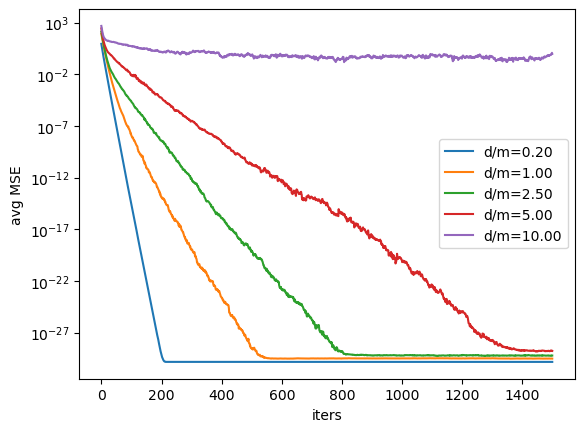

In [68]:
for item in range(len(d_over_m)):
    plt.plot([i for i in range(len(loss_dm_algo[item]))], loss_dm_algo[item], label='d/m=%.2f' % d_over_m[item])
plt.yscale('log')
plt.xlabel('iters')
plt.ylabel('avg MSE')
plt.legend()
plt.show()